    • ID: ID of each client
    • LIMIT_BAL: Amount of given credit in NT dollars (includes individual and family/supplementary credit
    • SEX: Gender (1=male, 2=female)
    • EDUCATION: (1=graduate school, 2=university, 3=high school, 4=others, 5=unknown, 6=unknown)
    • MARRIAGE: Marital status (1=married, 2=single, 3=others)
    • AGE: Age in years
    • PAY_0: Repayment status in September, 2005 (-1=pay duly, 1=payment delay for one month, 2=payment delay for two months, … 8=payment delay for eight months, 9=payment delay for nine months and above)
    • PAY_2: Repayment status in August, 2005 (scale same as above)
    • PAY_3: Repayment status in July, 2005 (scale same as above)
    • PAY_4: Repayment status in June, 2005 (scale same as above)
    • PAY_5: Repayment status in May, 2005 (scale same as above)
    • PAY_6: Repayment status in April, 2005 (scale same as above)
    • BILL_AMT1: Amount of bill statement in September, 2005 (NT dollar)
    • BILL_AMT2: Amount of bill statement in August, 2005 (NT dollar)
    • BILL_AMT3: Amount of bill statement in July, 2005 (NT dollar)
    • BILL_AMT4: Amount of bill statement in June, 2005 (NT dollar)
    • BILL_AMT5: Amount of bill statement in May, 2005 (NT dollar)
    • BILL_AMT6: Amount of bill statement in April, 2005 (NT dollar)
    • PAY_AMT1: Amount of previous payment in September, 2005 (NT dollar)
    • PAY_AMT2: Amount of previous payment in August, 2005 (NT dollar)
    • PAY_AMT3: Amount of previous payment in July, 2005 (NT dollar)
    • PAY_AMT4: Amount of previous payment in June, 2005 (NT dollar)
    • PAY_AMT5: Amount of previous payment in May, 2005 (NT dollar)
    • PAY_AMT6: Amount of previous payment in April, 2005 (NT dollar)
    • default.payment.next.month: Default payment (1=yes, 0=no)

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder, StandardScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, RandomizedSearchCV
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, ConfusionMatrixDisplay, roc_auc_score, classification_report
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, median_absolute_error
from imblearn.combine import SMOTETomek
from imblearn.pipeline import Pipeline
from xgboost import XGBClassifier, XGBRegressor
from sklearn.compose import ColumnTransformer
from catboost import CatBoostRegressor, Pool
from scipy.stats import randint, uniform

from sklearn.linear_model import LogisticRegression, Ridge, HuberRegressor

In [3]:
data = pd.read_excel('./../data/defalut_credit_card_clients.xls', skiprows=1,header=0)
data.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
0,1,20000,2,2,1,24,2,2,-1,-1,...,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,-1,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2,1,37,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2,1,57,-1,0,-1,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


# EDA

In [4]:
data.info() # no missig values!

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 25 columns):
 #   Column                      Non-Null Count  Dtype
---  ------                      --------------  -----
 0   ID                          30000 non-null  int64
 1   LIMIT_BAL                   30000 non-null  int64
 2   SEX                         30000 non-null  int64
 3   EDUCATION                   30000 non-null  int64
 4   MARRIAGE                    30000 non-null  int64
 5   AGE                         30000 non-null  int64
 6   PAY_0                       30000 non-null  int64
 7   PAY_2                       30000 non-null  int64
 8   PAY_3                       30000 non-null  int64
 9   PAY_4                       30000 non-null  int64
 10  PAY_5                       30000 non-null  int64
 11  PAY_6                       30000 non-null  int64
 12  BILL_AMT1                   30000 non-null  int64
 13  BILL_AMT2                   30000 non-null  int64
 14  BILL_A

In [5]:
if data.duplicated().any(): ##no duplicated rows
    data.drop_duplicates(keep='first', inplace=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 25 columns):
 #   Column                      Non-Null Count  Dtype
---  ------                      --------------  -----
 0   ID                          30000 non-null  int64
 1   LIMIT_BAL                   30000 non-null  int64
 2   SEX                         30000 non-null  int64
 3   EDUCATION                   30000 non-null  int64
 4   MARRIAGE                    30000 non-null  int64
 5   AGE                         30000 non-null  int64
 6   PAY_0                       30000 non-null  int64
 7   PAY_2                       30000 non-null  int64
 8   PAY_3                       30000 non-null  int64
 9   PAY_4                       30000 non-null  int64
 10  PAY_5                       30000 non-null  int64
 11  PAY_6                       30000 non-null  int64
 12  BILL_AMT1                   30000 non-null  int64
 13  BILL_AMT2                   30000 non-null  int64
 14  BILL_A

<Axes: >

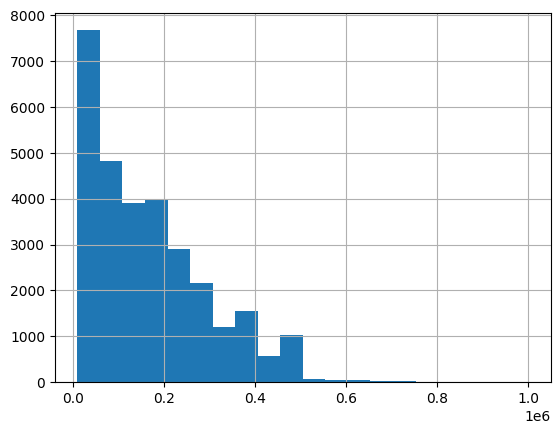

In [6]:
data['LIMIT_BAL'].hist(bins=20)

<Axes: xlabel='SEX'>

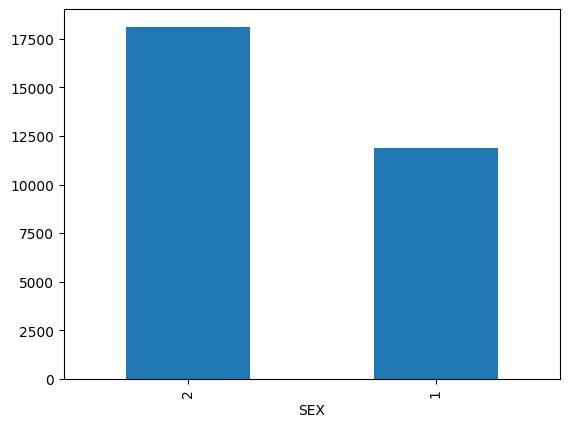

In [7]:
data['SEX'].value_counts().plot.bar() #use one_hot encoding

<Axes: xlabel='EDUCATION'>

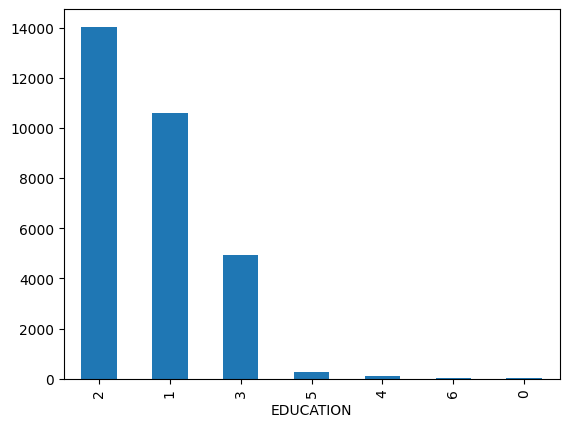

In [8]:
data['EDUCATION'].value_counts().plot.bar() ## 0 is undocumented, use one_hot_encoding

<Axes: xlabel='MARRIAGE'>

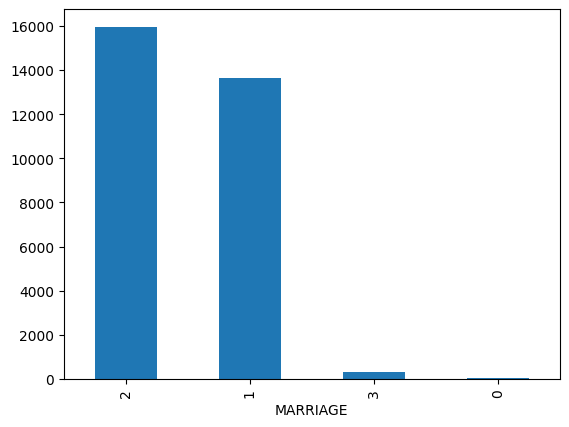

In [9]:
data['MARRIAGE'].value_counts().plot.bar()  ### 0 is unducomented, use one_hot_encoding

<Axes: >

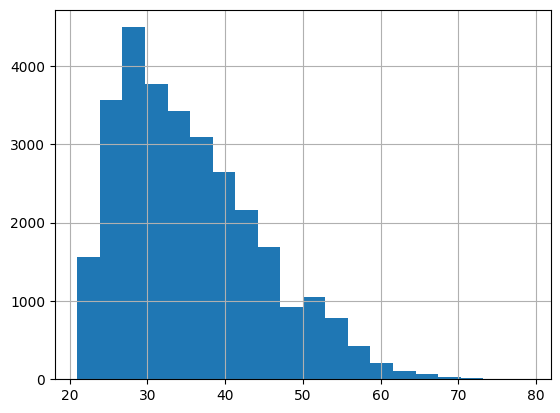

In [10]:
data['AGE'].hist(bins=20)

In [11]:
def plot_histograms(data, variables, n_rows, n_cols, n_bins):
    fig=plt.figure()
    for i, var_name in enumerate(variables):
        ax=fig.add_subplot(n_rows,n_cols,i+1)
        data[var_name].hist(bins=n_bins,ax=ax)
        ax.set_title(var_name)
    fig.tight_layout()  # Improves appearance a bit.
    plt.show()

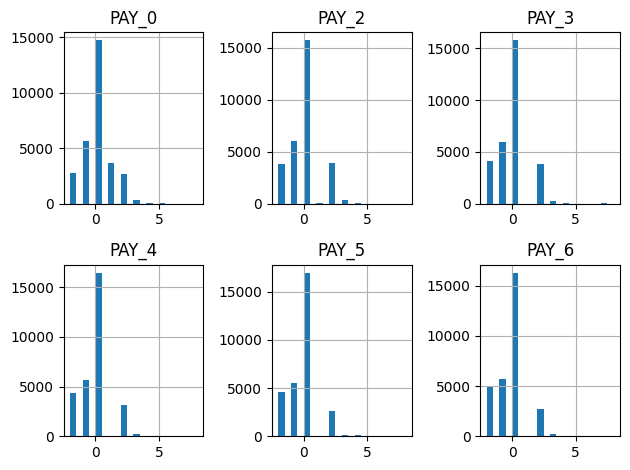

In [12]:
variables1 = ['PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6']
plot_histograms(data, variables1, 2, 3, 20)

In [13]:
data[variables1].describe() ###-2 and 0 are out of the description of dataset

,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6
count,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000
mean,-0.016700,-0.133767,-0.166200,-0.220667,-0.266200,-0.291100
std,1.123802,1.197186,1.196868,1.169139,1.133187,1.149988
min,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000
25%,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000


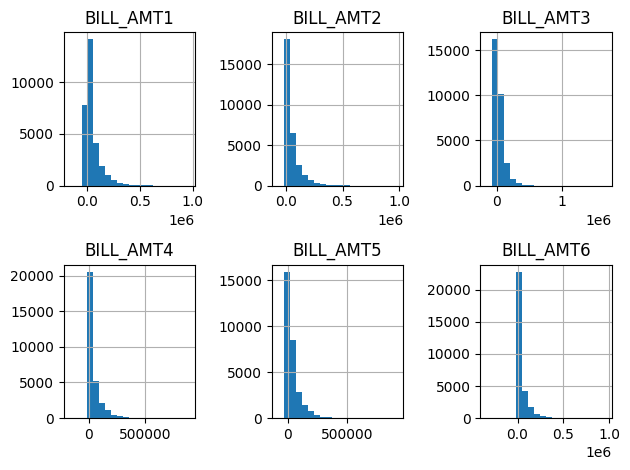

In [14]:
variables2 = ['BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6']
plot_histograms(data, variables2, 2,3,20)

In [15]:
data[variables2].describe() ### it has negative values

,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6
count,30000.000000,30000.000000,3.000000e+04,30000.000000,30000.000000,30000.000000
mean,51223.330900,49179.075167,4.701315e+04,43262.948967,40311.400967,38871.760400
std,73635.860576,71173.768783,6.934939e+04,64332.856134,60797.155770,59554.107537
min,-165580.000000,-69777.000000,-1.572640e+05,-170000.000000,-81334.000000,-339603.000000
25%,3558.750000,2984.750000,2.666250e+03,2326.750000,1763.000000,1256.000000
50%,22381.500000,21200.000000,2.008850e+04,19052.000000,18104.500000,17071.000000
75%,67091.000000,64006.250000,6.016475e+04,54506.000000,50190.500000,49198.250000
max,964511.000000,983931.000000,1.664089e+06,891586.000000,927171.000000,961664.000000


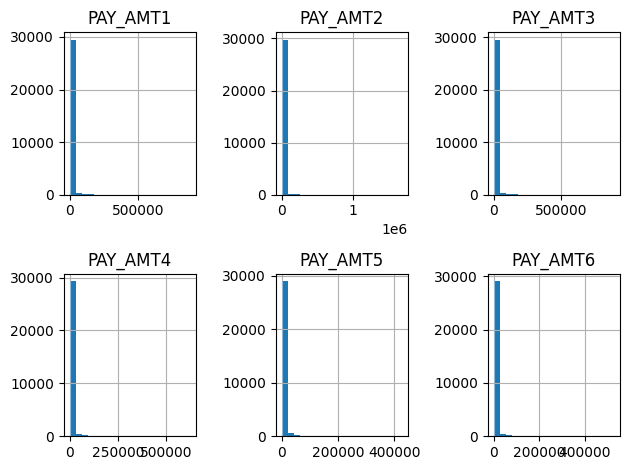

In [16]:
variables3 = ['PAY_AMT1','PAY_AMT2','PAY_AMT3','PAY_AMT4','PAY_AMT5','PAY_AMT6']
plot_histograms(data, variables3, 2,3,20)

In [17]:
data[variables3].describe()

,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6
count,30000.000000,3.000000e+04,30000.00000,30000.000000,30000.000000,30000.000000
mean,5663.580500,5.921163e+03,5225.68150,4826.076867,4799.387633,5215.502567
std,16563.280354,2.304087e+04,17606.96147,15666.159744,15278.305679,17777.465775
min,0.000000,0.000000e+00,0.00000,0.000000,0.000000,0.000000
25%,1000.000000,8.330000e+02,390.00000,296.000000,252.500000,117.750000
50%,2100.000000,2.009000e+03,1800.00000,1500.000000,1500.000000,1500.000000
75%,5006.000000,5.000000e+03,4505.00000,4013.250000,4031.500000,4000.000000
max,873552.000000,1.684259e+06,896040.00000,621000.000000,426529.000000,528666.000000


In [18]:
cols = ['PAY_0', 'PAY_2', 'PAY_3','PAY_4','PAY_5', 'PAY_6', 'BILL_AMT1','BILL_AMT2','BILL_AMT3','BILL_AMT4','BILL_AMT5','BILL_AMT6','PAY_AMT1','PAY_AMT2','PAY_AMT3','PAY_AMT4','PAY_AMT5','PAY_AMT6','default payment next month']


In [19]:
data[ data['BILL_AMT6'] < 0 ][cols] ##negative balances, many -1,0,-2 in PAY_i

,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
26,1,-2,-1,-1,-1,-1,-109,-425,259,-57,127,-189,0,1000,0,500,0,1000,1
35,-1,-1,-2,-2,-2,-1,30265,-131,-527,-923,-1488,-1884,131,396,396,565,792,0,0
109,1,-2,-2,-2,-2,-2,-103,-103,-103,-103,-103,-103,0,0,0,0,0,0,0
134,0,0,0,0,0,0,28452,26145,26712,25350,17603,-780,2000,1400,0,500,0,1560,0
167,-1,2,2,0,0,0,102349,96847,58824,29336,22979,-246,3166,0,1330,1398,12,50000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29862,0,0,0,0,0,-2,1529,5404,3853,4768,-52,-52,1200,1200,1020,0,0,7000,1
29921,0,0,0,-1,-1,-1,468749,411016,420393,1467,1421,-15,17259,18600,1474,1428,0,0,1
29922,1,-2,-2,-2,-2,-2,-18,-18,-18,-18,-18,-18,0,0,0,0,0,0,0
29931,0,0,0,0,0,0,61118,50643,44004,26940,9971,-11798,2200,2000,1200,0,0,28000,0


In [20]:
data.columns

Index(['ID', 'LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_0',
       'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2',
       'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1',
       'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6',
       'default payment next month'],
      dtype='object')

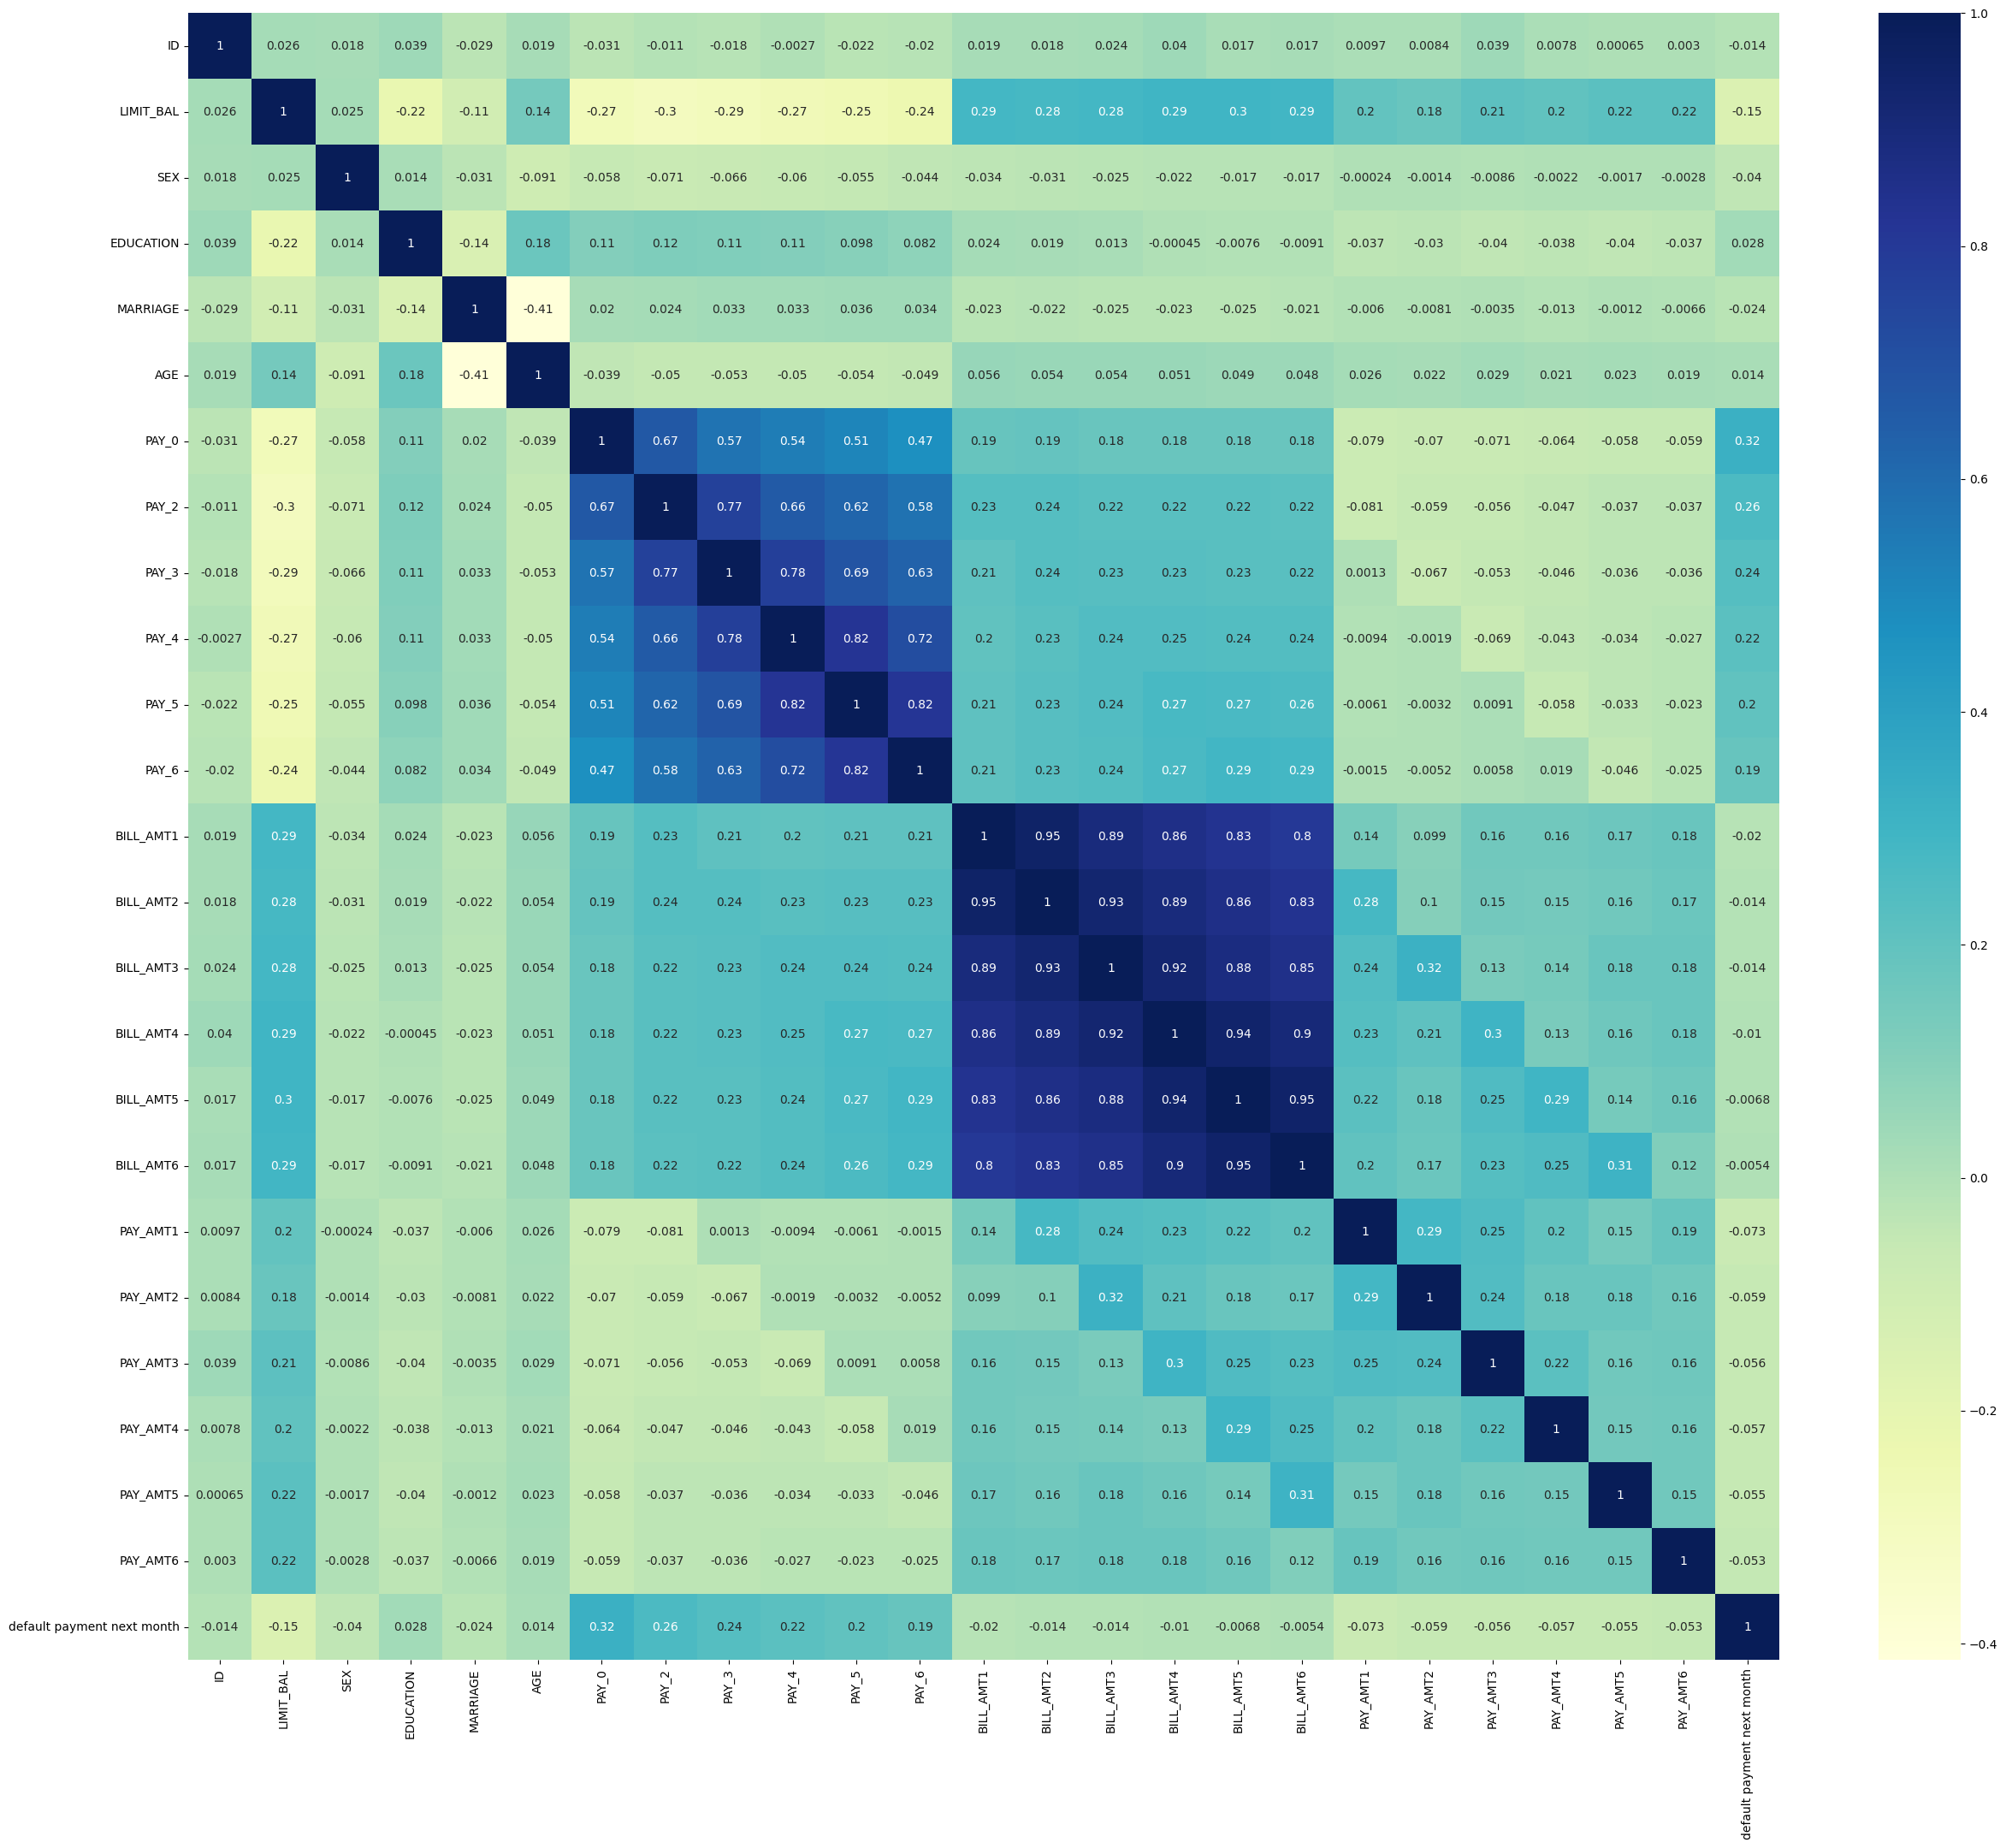

In [21]:
plt.figure(figsize=(30,25))
sns.heatmap(data.corr(), annot=True, cmap = 'YlGnBu')
plt.show()


In [22]:
### high correlations between PAY_i variables, and between BILL_AMTi.!!!!

In [23]:
## what are -2 and 0 for PAY_? it seems tha 

array([[<Axes: title={'center': 'BILL_AMT1'}>,
        <Axes: title={'center': 'PAY_AMT1'}>]], dtype=object)

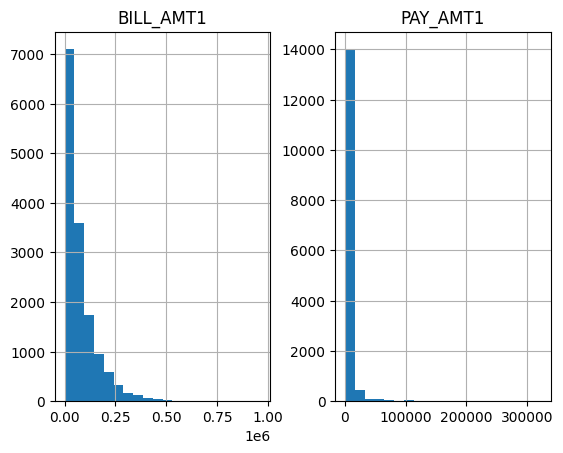

In [24]:
data[data['PAY_0']==0][['BILL_AMT1', 'PAY_AMT1']].hist(bins=20,) ##not many payments

array([[<Axes: title={'center': 'BILL_AMT1'}>,
        <Axes: title={'center': 'PAY_AMT1'}>]], dtype=object)

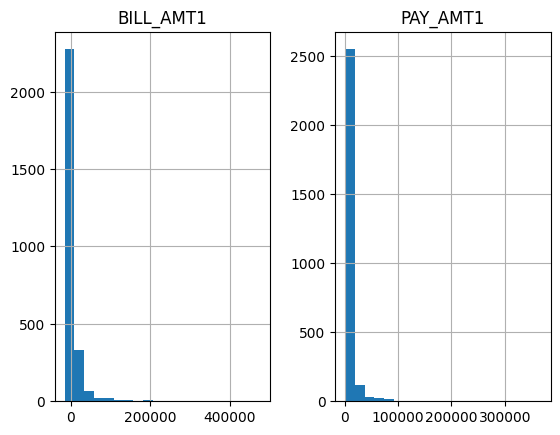

In [25]:
data[data['PAY_0']==-2][['BILL_AMT1', 'PAY_AMT1']].hist(bins=20)

array([[<Axes: title={'center': 'BILL_AMT1'}>,
        <Axes: title={'center': 'PAY_AMT1'}>]], dtype=object)

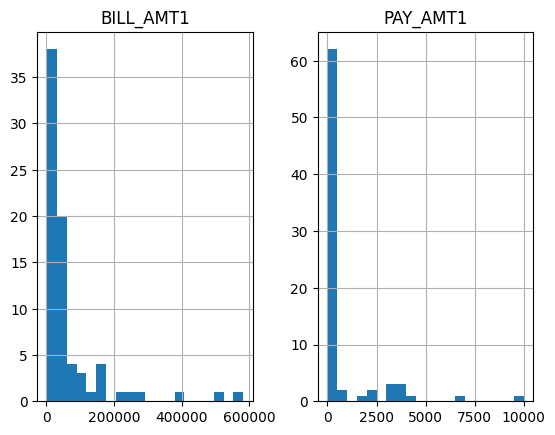

In [26]:
data[data['PAY_0']==4][['BILL_AMT1', 'PAY_AMT1']].hist(bins=20)

In [27]:
data[data['PAY_2']==2][['BILL_AMT2', 'PAY_AMT3']].mean()

BILL_AMT2    50453.511077
PAY_AMT3      2751.442832
dtype: float64

In [28]:
data[data['PAY_2']==0][['BILL_AMT2', 'PAY_AMT3']].mean()

BILL_AMT2    74629.304959
PAY_AMT3      5173.885887
dtype: float64

default payment next month
0    0.7788
1    0.2212
Name: proportion, dtype: float64


<Axes: xlabel='default payment next month'>

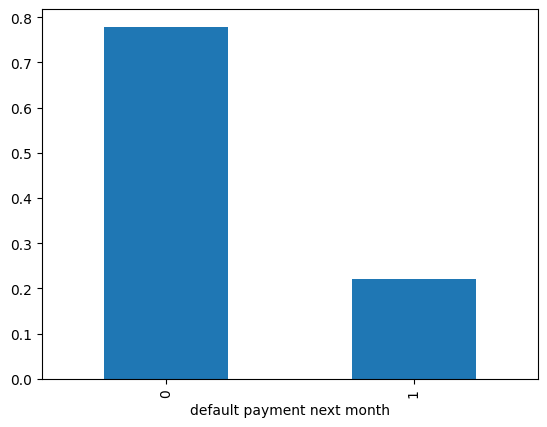

In [29]:
print(data['default payment next month'].value_counts(normalize=True))
data['default payment next month'].value_counts(normalize=True).plot.bar()  #imbalanced dataset

In [30]:
ratio_weight = 0.7788/0.2212
ratio_weight

3.5207956600361663

In [31]:
target = data.corr()['default payment next month'].drop('default payment next month')
target

ID          -0.013952
LIMIT_BAL   -0.153520
SEX         -0.039961
EDUCATION    0.028006
MARRIAGE    -0.024339
AGE          0.013890
PAY_0        0.324794
PAY_2        0.263551
PAY_3        0.235253
PAY_4        0.216614
PAY_5        0.204149
PAY_6        0.186866
BILL_AMT1   -0.019644
BILL_AMT2   -0.014193
BILL_AMT3   -0.014076
BILL_AMT4   -0.010156
BILL_AMT5   -0.006760
BILL_AMT6   -0.005372
PAY_AMT1    -0.072929
PAY_AMT2    -0.058579
PAY_AMT3    -0.056250
PAY_AMT4    -0.056827
PAY_AMT5    -0.055124
PAY_AMT6    -0.053183
Name: default payment next month, dtype: float64

<Axes: ylabel='None'>

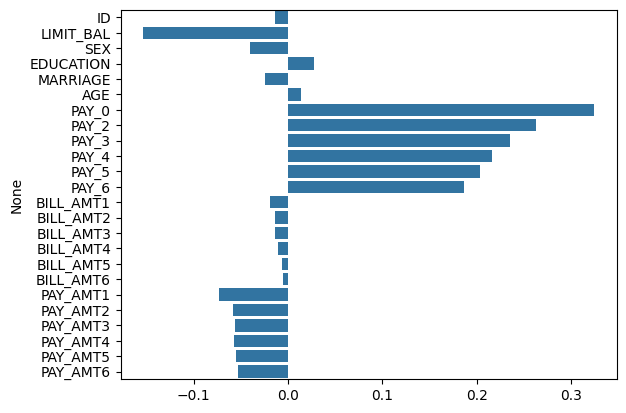

In [32]:
sns.barplot(y=target.index, x=target.values, orient='h')

# Data Cleaning

In [33]:
df=data.copy()
df.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
0,1,20000,2,2,1,24,2,2,-1,-1,...,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,-1,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2,1,37,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2,1,57,-1,0,-1,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


In [34]:
df = df.rename(columns={'default payment next month':'default_pnm', 'PAY_0':'PAY_1'})
df.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_1,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default_pnm
0,1,20000,2,2,1,24,2,2,-1,-1,...,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,-1,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2,1,37,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2,1,57,-1,0,-1,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


In [35]:
df.default_pnm.sum()/len(df.default_pnm)

0.2212

In [36]:
##for education, putting 5 (unknown), 6(unknown), and 0 (?) in class 4 (others)
idx_ed = (df.EDUCATION == 5) | (df.EDUCATION ==6) | (df.EDUCATION ==0)
df.loc[idx_ed, 'EDUCATION'] = 4
df.EDUCATION.value_counts()

EDUCATION
2    14030
1    10585
3     4917
4      468
Name: count, dtype: int64

In [37]:
##for marriage, putting 0 (?) into class 3(others)
idx_marr = df.MARRIAGE == 0
df.loc[idx_marr, 'MARRIAGE'] = 3
df.MARRIAGE.value_counts()

MARRIAGE
2    15964
1    13659
3      377
Name: count, dtype: int64

In [38]:
#for PAY_i, putting -2, 0 toghether in class -1 (pay-duly)
for i in range(1, 7):
    idx = (df[f'PAY_{i}'] == -2) | (df[f'PAY_{i}'] == 0)
    df.loc[idx, f'PAY_{i}'] = -1
    print(df[f'PAY_{i}'].value_counts())

PAY_1
-1    23182
 1     3688
 2     2667
 3      322
 4       76
 5       26
 8       19
 6       11
 7        9
Name: count, dtype: int64
PAY_2
-1    25562
 2     3927
 3      326
 4       99
 1       28
 5       25
 7       20
 6       12
 8        1
Name: count, dtype: int64
PAY_3
-1    25787
 2     3819
 3      240
 4       76
 7       27
 6       23
 5       21
 1        4
 8        3
Name: count, dtype: int64
PAY_4
-1    26490
 2     3159
 3      180
 4       69
 7       58
 5       35
 6        5
 1        2
 8        2
Name: count, dtype: int64
PAY_5
-1    27032
 2     2626
 3      178
 4       84
 7       58
 5       17
 6        4
 8        1
Name: count, dtype: int64
PAY_6
-1    26921
 2     2766
 3      184
 4       49
 7       46
 6       19
 5       13
 8        2
Name: count, dtype: int64


In [39]:
df = df.drop('ID', axis=1)

In [40]:
df.describe()

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default_pnm
count,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,...,30000.000000,30000.000000,30000.000000,30000.000000,3.000000e+04,30000.00000,30000.000000,30000.000000,30000.000000,30000.000000
mean,167484.322667,1.603733,1.842267,1.557267,35.485500,-0.415967,-0.532033,-0.555500,-0.624233,-0.679567,...,43262.948967,40311.400967,38871.760400,5663.580500,5.921163e+03,5225.68150,4826.076867,4799.387633,5215.502567,0.221200
std,129747.661567,0.489129,0.744494,0.521405,9.217904,1.142591,1.146393,1.126275,1.067522,1.001726,...,64332.856134,60797.155770,59554.107537,16563.280354,2.304087e+04,17606.96147,15666.159744,15278.305679,17777.465775,0.415062
min,10000.000000,1.000000,1.000000,1.000000,21.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,-170000.000000,-81334.000000,-339603.000000,0.000000,0.000000e+00,0.00000,0.000000,0.000000,0.000000,0.000000
25%,50000.000000,1.000000,1.000000,1.000000,28.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,2326.750000,1763.000000,1256.000000,1000.000000,8.330000e+02,390.00000,296.000000,252.500000,117.750000,0.000000
50%,140000.000000,2.000000,2.000000,2.000000,34.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,19052.000000,18104.500000,17071.000000,2100.000000,2.009000e+03,1800.00000,1500.000000,1500.000000,1500.000000,0.000000
75%,240000.000000,2.000000,2.000000,2.000000,41.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,54506.000000,50190.500000,49198.250000,5006.000000,5.000000e+03,4505.00000,4013.250000,4031.500000,4000.000000,0.000000
max,1000000.000000,2.000000,4.000000,3.000000,79.000000,8.000000,8.000000,8.000000,8.000000,8.000000,...,891586.000000,927171.000000,961664.000000,873552.000000,1.684259e+06,896040.00000,621000.000000,426529.000000,528666.000000,1.000000


#### one hot encoding

In [41]:
##one hot encoding
features_ohe = ['SEX', 'MARRIAGE', 'EDUCATION']
df_categorical = df[features_ohe]
ohe = OneHotEncoder(sparse_output=False)
encoded_features = ohe.fit_transform(df_categorical)
df_ohe = pd.DataFrame(encoded_features, columns=ohe.get_feature_names_out(features_ohe))
df_encoded = pd.concat( [df.drop(columns=features_ohe), df_ohe], axis=1)
df_encoded

,LIMIT_BAL,AGE,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,...,default_pnm,SEX_1,SEX_2,MARRIAGE_1,MARRIAGE_2,MARRIAGE_3,EDUCATION_1,EDUCATION_2,EDUCATION_3,EDUCATION_4
0,20000,24,2,2,-1,-1,-1,-1,3913,3102,...,1,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
1,120000,26,-1,2,-1,-1,-1,2,2682,1725,...,1,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
2,90000,34,-1,-1,-1,-1,-1,-1,29239,14027,...,0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
3,50000,37,-1,-1,-1,-1,-1,-1,46990,48233,...,0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
4,50000,57,-1,-1,-1,-1,-1,-1,8617,5670,...,0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29995,220000,39,-1,-1,-1,-1,-1,-1,188948,192815,...,0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
29996,150000,43,-1,-1,-1,-1,-1,-1,1683,1828,...,0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
29997,30000,37,4,3,2,-1,-1,-1,3565,3356,...,1,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
29998,80000,41,1,-1,-1,-1,-1,-1,-1645,78379,...,1,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0


In [42]:
ohe.get_feature_names_out()

array(['SEX_1', 'SEX_2', 'MARRIAGE_1', 'MARRIAGE_2', 'MARRIAGE_3',
       'EDUCATION_1', 'EDUCATION_2', 'EDUCATION_3', 'EDUCATION_4'],
      dtype=object)

In [43]:
output_path = "./../data/df_encoded.csv"
df_encoded.to_csv(output_path, index=False)
print(f"Preprocessed dataset saved to {output_path}")

Preprocessed dataset saved to ./../data/df_encoded.csv


In [44]:
# Exploring target variable for regression

Count: 30000
Missing: 0
Mean: 4826.076866666666
Median: 1500.0
Std: 15666.159744032007
Min, Max: 0 621000
Percentiles:
0.00         0.00
0.01         0.00
0.05         0.00
0.10         0.00
0.25       296.00
0.50      1500.00
0.75      4013.25
0.90      9570.60
0.95     16014.95
0.99     67054.44
1.00    621000.00
Name: PAY_AMT4, dtype: float64
Zeros: 6408 (21.36%)
Payments <= 1000: 12782 (42.61%)
Skew: 12.904984823542545
Kurtosis: 277.3337677160758
log1p mean: 6.0777162229606665 log1p std: 3.396597986158929
log1p percentiles:
0.00     0.000000
0.01     0.000000
0.05     0.000000
0.10     0.000000
0.25     5.693732
0.50     7.313887
0.75     8.297606
0.90     9.166556
0.95     9.681340
0.99    11.113275
1.00    13.339088
Name: PAY_AMT4, dtype: float64


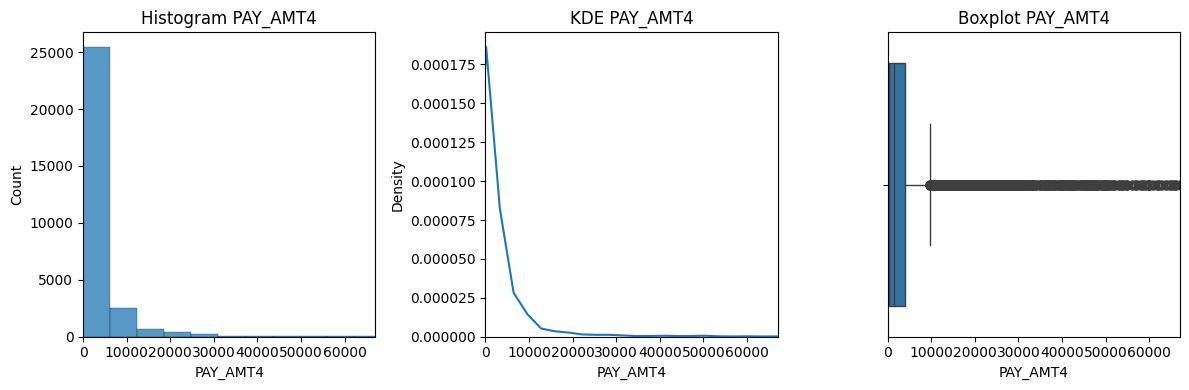

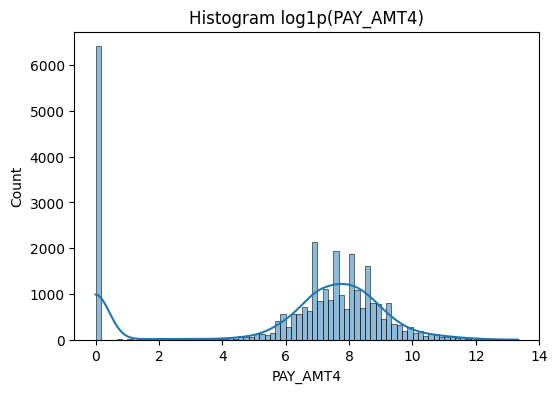

99th percentile: 67054.43999999961 99.9th: 200396.60500000615
Count > 99th: 300 Count > 99.9th: 30
Top 10 PAY_AMT4 values:
28716    621000
24686    528897
3183     497000
14553    432130
11557    400046
8355     331788
4209     330982
23013    320008
13683    313094
15412    292962
Name: PAY_AMT4, dtype: int64


In [45]:
y = df["PAY_AMT4"]
# Resumen numérico
print("Count:", y.count())
print("Missing:", y.isna().sum())
print("Mean:", y.mean())
print("Median:", y.median())
print("Std:", y.std())
print("Min, Max:", y.min(), y.max())
print("Percentiles:")
print(y.quantile([0,0.01,0.05,0.1,0.25,0.5,0.75,0.9,0.95,0.99,1.0]))

# Zeros and small payments
n_zeros = (y == 0).sum()
print("Zeros:", n_zeros, f"({n_zeros/len(y):.2%})")
print("Payments <= 1000:", (y <= 1000).sum(), f"({(y <= 1000).mean():.2%})")

# Skewness and kurtosis
print("Skew:", y.skew())
print("Kurtosis:", y.kurtosis())

# Log-transform summary (useful if many zeros -> log1p)
y_log = np.log1p(y)
print("log1p mean:", y_log.mean(), "log1p std:", y_log.std())
print("log1p percentiles:")
print(pd.Series(y_log).quantile([0,0.01,0.05,0.1,0.25,0.5,0.75,0.9,0.95,0.99,1.0]))

# Plots
plt.figure(figsize=(12,4))
plt.subplot(1,3,1)
sns.histplot(y, bins=100, kde=False)
plt.title("Histogram PAY_AMT4")
plt.xlim(0, np.percentile(y, 99))  # focus on main bulk; change or remove to see full tail

plt.subplot(1,3,2)
sns.kdeplot(y, bw_adjust=0.5)
plt.title("KDE PAY_AMT4")
plt.xlim(0, np.percentile(y, 99))

plt.subplot(1,3,3)
sns.boxplot(x=y)
plt.title("Boxplot PAY_AMT4")
plt.xlim(0, np.percentile(y, 99))

plt.tight_layout()
plt.show()

# Histogram of log1p
plt.figure(figsize=(6,4))
sns.histplot(y_log, bins=80, kde=True)
plt.title("Histogram log1p(PAY_AMT4)")
plt.show()

# Identify extreme outliers (e.g., above 99th or 99.9th percentile)
p99 = y.quantile(0.99)
p999 = y.quantile(0.999)
print("99th percentile:", p99, "99.9th:", p999)
print("Count > 99th:", (y > p99).sum(), "Count > 99.9th:", (y > p999).sum())

# Show top 10 largest payments
print("Top 10 PAY_AMT4 values:")
print(y.sort_values(ascending=False).head(10))

In [46]:
def chart_price_normal(y_target):
    import seaborn as sns
    import matplotlib.pyplot as plt
    import matplotlib.gridspec as gridspec
    from scipy import stats
    import matplotlib.style as style

    def warn(*args, **kwargs):
        pass
    import warnings
    warnings.warn = warn

    fig = plt.figure(constrained_layout =True, figsize=(12,8))

    #creating a grid
    grid = gridspec.GridSpec(ncols=3, nrows=2, figure=fig)

    ##customizin the histogram grid
    ax1 = fig.add_subplot(grid[0, :2])
    ax1.set_title('Histogram')
    sns.distplot(y_target, norm_hist=True, ax =ax1)
    plt.xlabel('price')

    #customizing the QQ_plot
    ax2 = fig.add_subplot(grid[1,:2])
    ax2.set_title('QQ_plot')
    stats.probplot(y_target, plot= ax2)

    #customizing the boxplot
    ax3 = fig.add_subplot(grid[:, 2])
    ax3.set_title('Box Plot Price')
    sns.boxplot(y_target, orient='v', ax=ax3)

    plt.show()


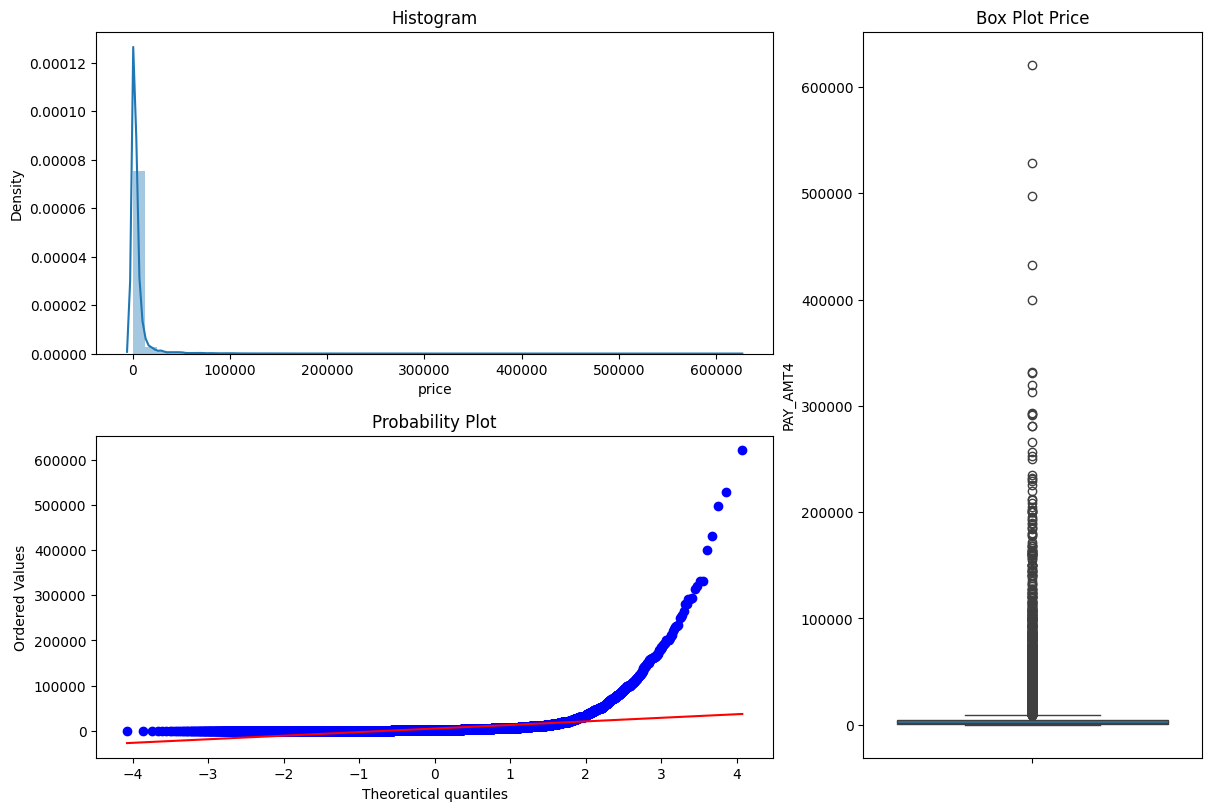

NormaltestResult(statistic=53681.82138303144, pvalue=0.0)


In [47]:
from scipy.stats.mstats import normaltest 
from scipy.stats import boxcox
#removing  some outliers
#iqr = y.quantile(0.75) - y.quantile(0.25)
#lim = np.abs((y - y.median()) / iqr) < 2.22
#df_ohe_nout = df_ohe.loc[lim.values,:].copy()
#y_nout = df_ohe_nout['price'].copy()

#y_bc, lamb_bc= boxcox(y_rtrain)
chart_price_normal(y)
print(normaltest(y))
#print('lambda= ', lamb_bc)


In [48]:
# compute caps from training target only (winsorize by percentiles)
lower_pct= 0.1##this does not remove the zeros
upper_pct = 0.9
low, high = np.quantile(y,  [lower_pct, upper_pct]) ##computed only on train set

# apply same caps to train and test
y_capped = np.clip(y, a_min=low, a_max=high) ###clapping only on the top



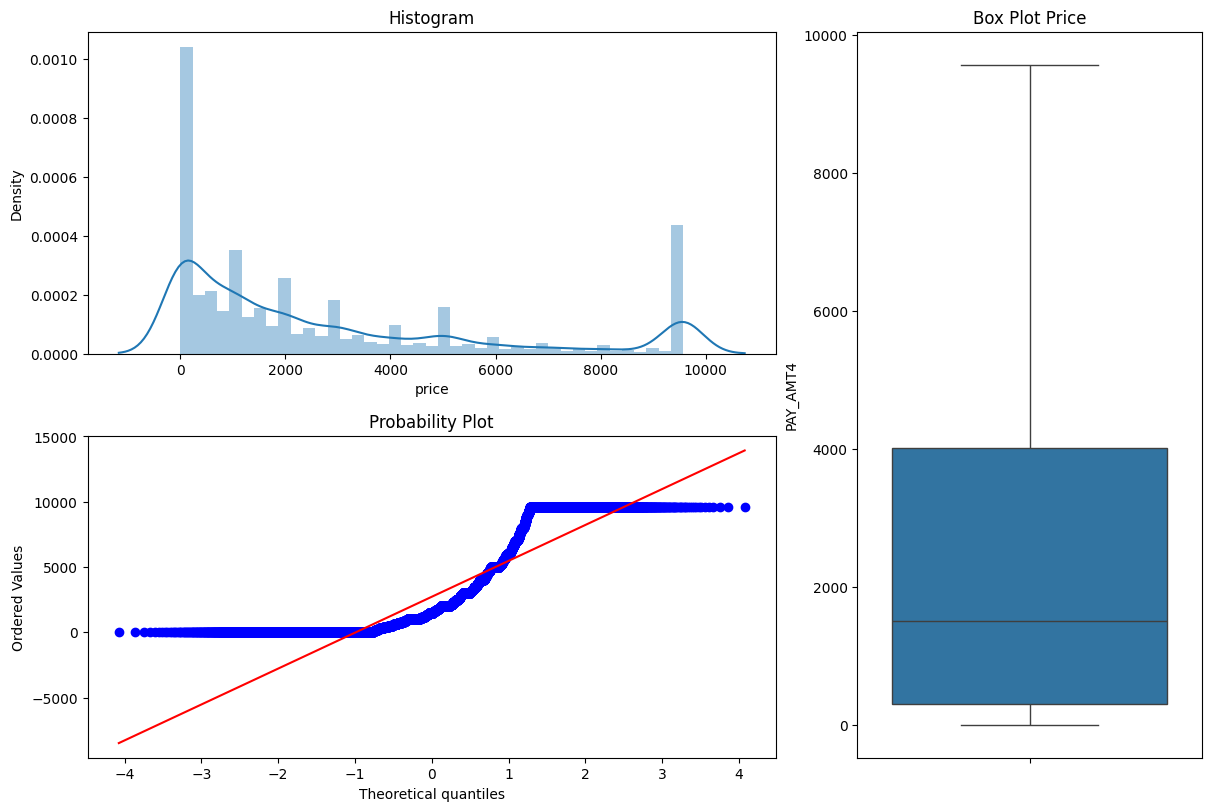

NormaltestResult(statistic=4509.55848640851, pvalue=0.0)


In [49]:
chart_price_normal(y_capped)
print(normaltest(y_capped))

In [50]:
y.describe()

count     30000.000000
mean       4826.076867
std       15666.159744
min           0.000000
25%         296.000000
50%        1500.000000
75%        4013.250000
max      621000.000000
Name: PAY_AMT4, dtype: float64

In [51]:
y_capped.describe()

count    30000.000000
mean      2716.445700
std       3069.166802
min          0.000000
25%        296.000000
50%       1500.000000
75%       4013.250000
max       9570.600000
Name: PAY_AMT4, dtype: float64